In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import datetime

# Read Data

In [33]:
%ls ../Datasets/211202NDAcquisition/CellSplit/NDAcquisition-02Nami_x40/NDAcquisition-02Nami_x40_XY109_4_0.tif

../Datasets/211202NDAcquisition/CellSplit/NDAcquisition-02Nami_x40/NDAcquisition-02Nami_x40_XY109_4_0.tif


In [45]:
# Data_02Nami=[]
# Data_01=[]
# path01="../Datasets/211202NDAcquisition/CellSplit/NDAcquisition-01x40/"
# path02="../Datasets/211202NDAcquisition/CellSplit/NDAcquisition-02Nami_x40/"
# for name in os.listdir(path01):
#     img=cv2.imread(path01+name)
#     Data_01.append(img)
# print("Data_01.shape:", len(Data_01))

# for name in os.listdir(path02):
#     img=cv2.imread(path02+name)
#     Data_02Nami.append(img)
# print("Data_02Nami.shape:", len(Data_02Nami))

Data_01.shape: 12149
Data_02Nami.shape: 1741


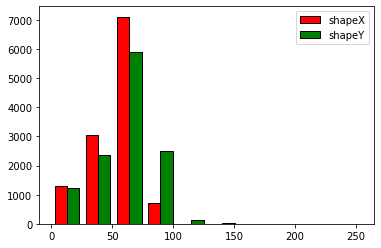

In [46]:
# shapeX=[]
# shapeY=[]
# for i in range(len(Data_01)):
#     shapeX.append(Data_01[i].shape[0])
#     shapeY.append(Data_01[i].shape[1])    
# fig, ax = plt.subplots()
# ax.hist([shapeX,shapeY], label=["shapeX", "shapeY"], color=["r", "g"], ec="k",range=[0,255])
# ax.legend()

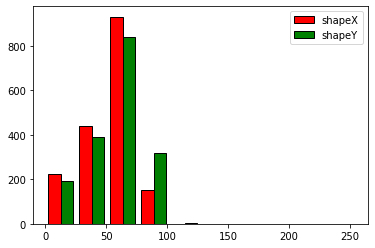

In [47]:
# shapeX=[]
# shapeY=[]
# for i in range(len(Data_02Nami)):
#     shapeX.append(Data_02Nami[i].shape[0])
#     shapeY.append(Data_02Nami[i].shape[1])    
# fig, ax = plt.subplots()
# ax.hist([shapeX,shapeY], label=["shapeX", "shapeY"], color=["r", "g"], ec="k",range=[0,255])
# ax.legend()

In [90]:
maxnum=0
for i in range(64,84):
    num=0
    for n in range(len(Data_01)):
        img = Data_01[n]
        if i<=img.shape[0]<=84 and i<=img.shape[1]<=84:
            num+=1
    if num >= maxnum:
        Max_shape_0=i
        Max_shape_1=i
        maxnum=num
print(Max_shape_0,Max_shape_1,maxnum)

64 64 1800


In [91]:
Max_shape_0=84
Max_shape_1=84
def pad(img):
    imgSize = img.shape
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    imgpad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    return imgpad

In [93]:
name02="NDAcquisition-02Nami_x40/NDAcquisition-02Nami_x40_"
name01="NDAcquisition-01x40/NDAcquisition-01x40_"
n=0
for i in range(len(Data_01)):
    img = Data_01[i]
    if 64<=img.shape[0]<=84 and 64<=img.shape[1]<=84:
        cv2.imwrite(name01+str(n)+".tif",pad(img))
        n+=1
print(n)  

n=0      
for i in range(len(Data_02Nami)):
    img = Data_02Nami[i]
    if 64<=img.shape[0]<=84 and 64<=img.shape[1]<=84:
        cv2.imwrite(name02+str(n)+".tif",pad(img))
        n+=1
print(n) 

1800
275


In [94]:
dataset=[]
for name in os.listdir("NDAcquisition-01x40/"):
    img=cv2.imread("NDAcquisition-01x40/"+name)
    dataset.append(img/255)
        
dataset=np.array(dataset)
print("dataset.shape",dataset.shape)

dataset = np.transpose(dataset, (0, 3, 1, 2))
print("dataset.shape",dataset.shape)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

dataset.shape (1800, 84, 84, 3)
dataset.shape (1800, 3, 84, 84)


# autoencoder

In [10]:
# test calculate
def convtest(w,f,s,p):
    n = (w-f+2*p)/s +1
    return(n)

def deconvtest(w,f,s,p):
    n = s*(w-1)+f-2*p
    return(n)
deconvtest(77,8,1,0)

84

In [95]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),  # b, 64, 42, 42
            nn.Tanh(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),  # b, 64, 42, 42
            nn.Tanh(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),  # b, 64, 21, 21
            nn.Tanh(),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),  # b, 32, 21, 21
            nn.Tanh(),
            nn.Conv2d(32, 16, 3, stride=2, padding=1),  # b, 16, 11, 11
            nn.Tanh(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1),  # b, 16, 6, 6
            nn.Tanh(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.Tanh(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1),  # b, 8, 2, 2
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 4, stride=2, padding=1),  # b, 16, 4, 4
            nn.Tanh(),
            nn.ConvTranspose2d(16, 32, 4, stride=2, padding=1),  # b, 32, 8, 8
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # b, 32, 16, 16
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # b, 32, 32, 32
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # b, 32, 64, 64
            nn.Tanh(),
            nn.ConvTranspose2d(32, 8, 8, stride=1, padding=1),  # b, 8, 69, 69
            nn.Tanh(),
            nn.ConvTranspose2d(8, 3, 8, stride=1, padding=1),  # b, 3, 74, 74
            nn.Tanh(),
            nn.ConvTranspose2d(3, 3, 8, stride=1, padding=1),  # b, 3, 79, 79
            nn.Tanh(),
            nn.ConvTranspose2d(3, 3, 8, stride=1, padding=1),  # b, 3, 84, 84
            nn.Tanh(),
        )

        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder().cuda()
criterion = nn.MSELoss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

starttime = datetime.datetime.now()

>>> epoch [1/1000], loss:0.0927, time:149.00s


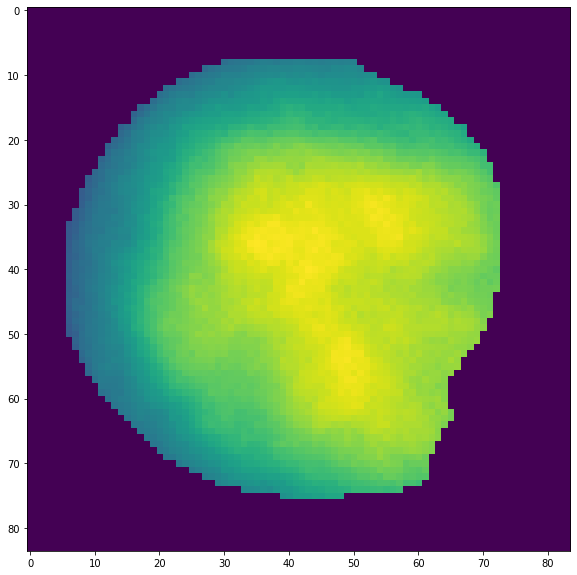

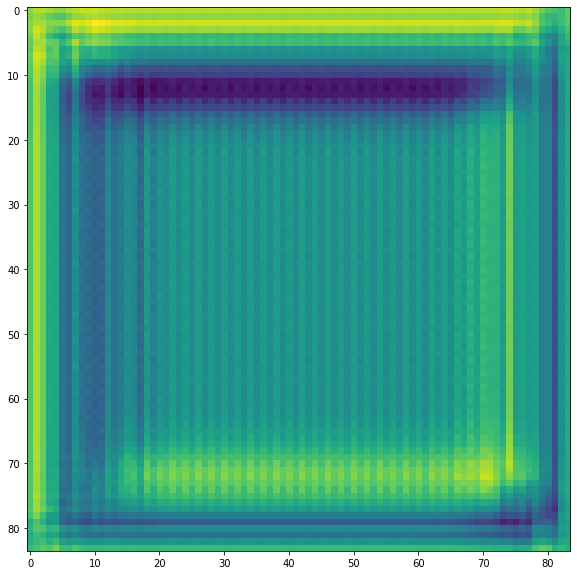

>>> epoch [101/1000], loss:0.0119, time:215.00s


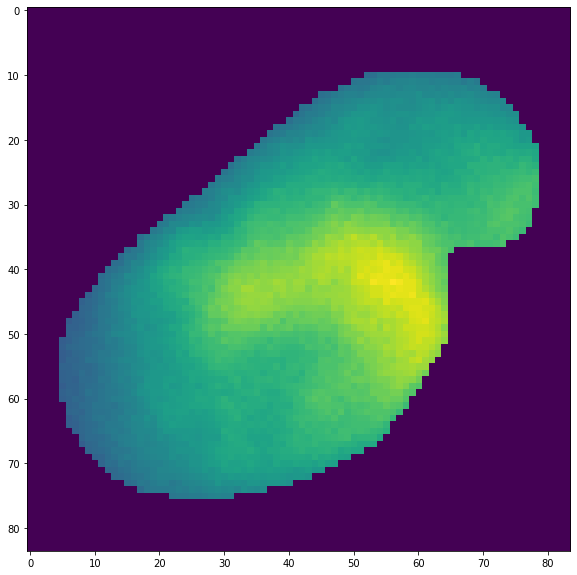

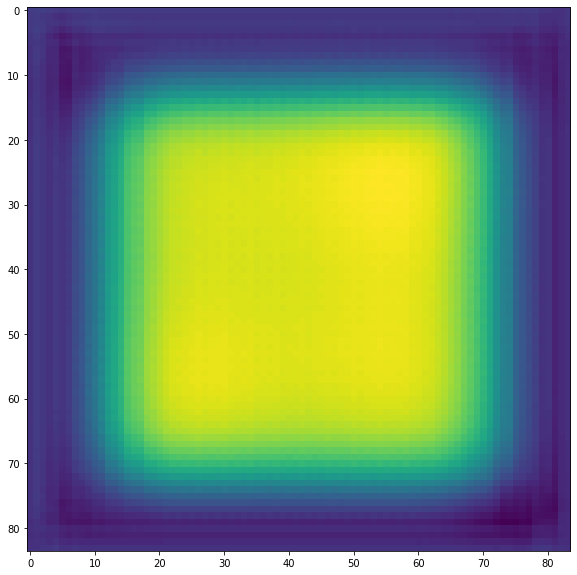

>>> epoch [201/1000], loss:0.0060, time:280.00s


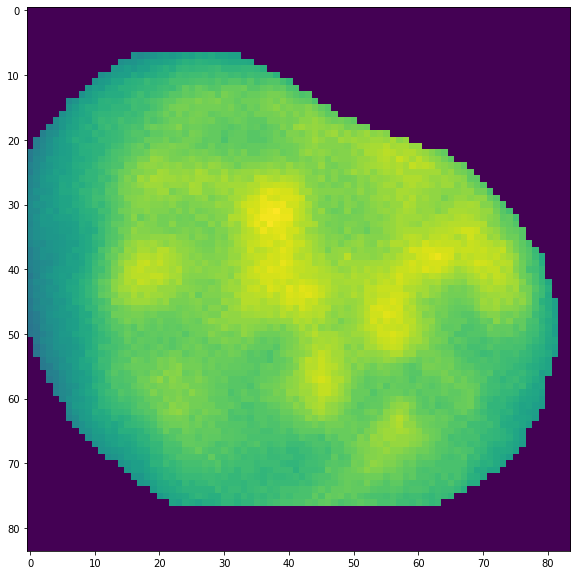

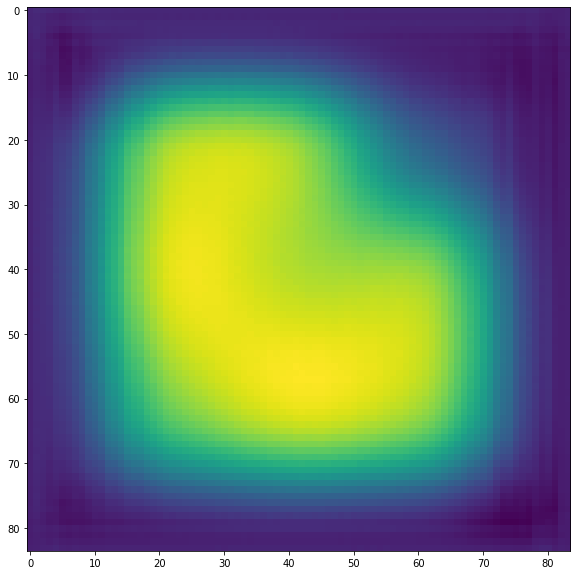

>>> epoch [301/1000], loss:0.0092, time:346.00s


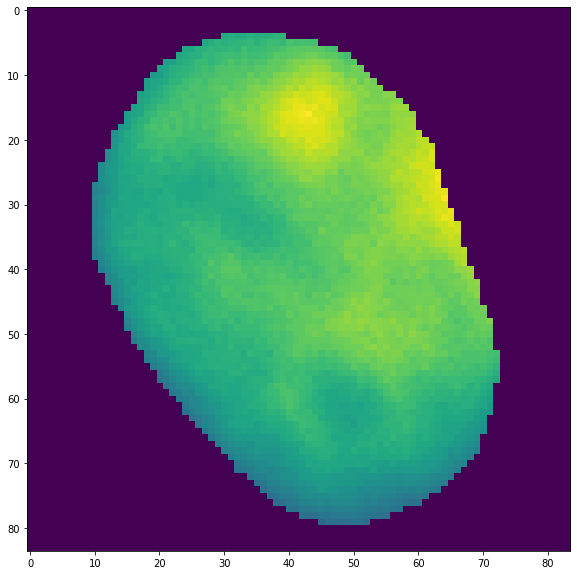

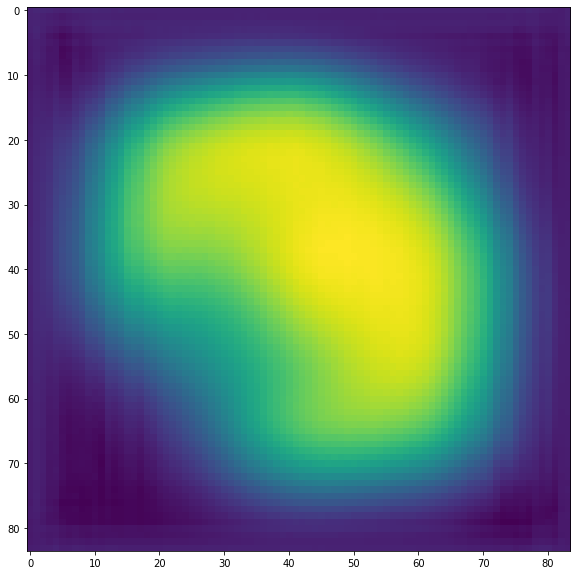

>>> epoch [401/1000], loss:0.0055, time:412.00s


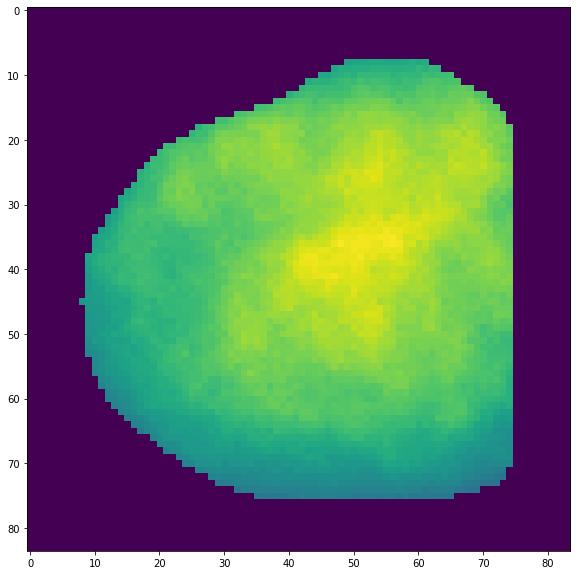

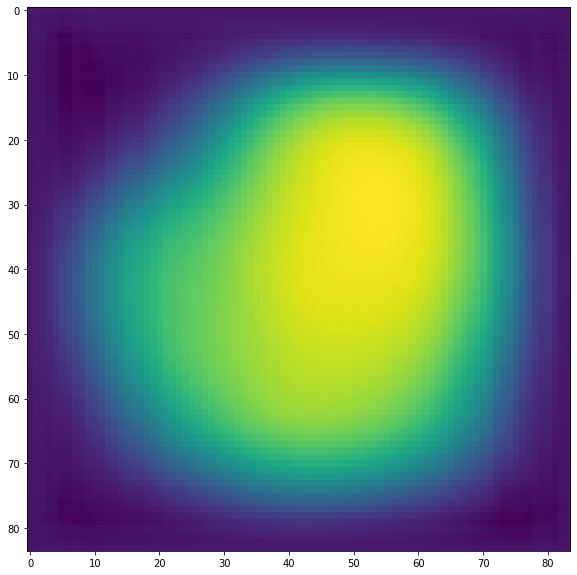

>>> epoch [501/1000], loss:0.0047, time:477.00s


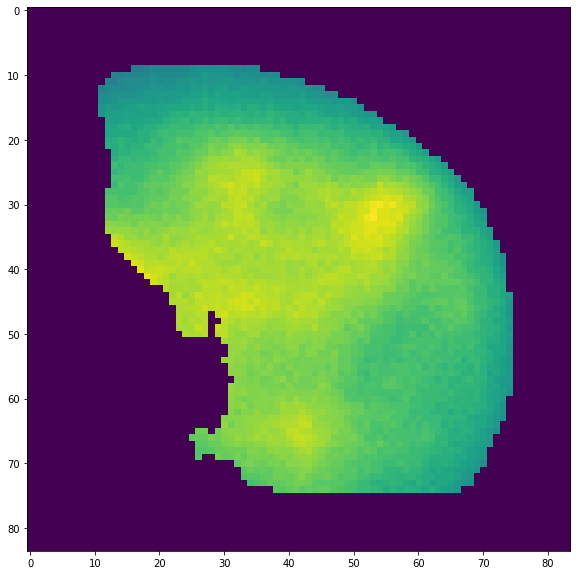

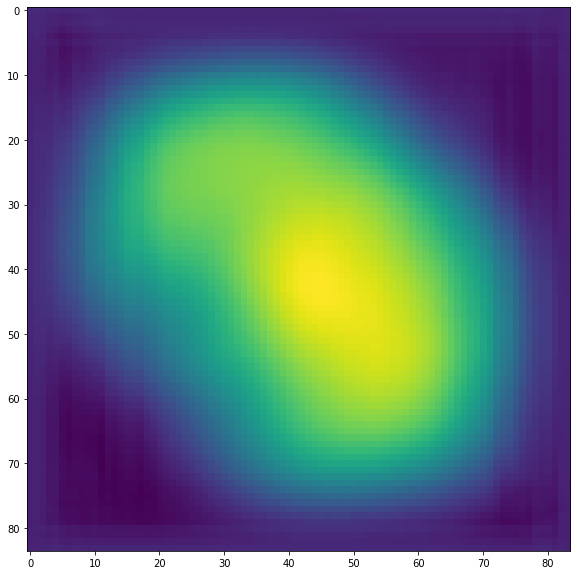

>>> epoch [601/1000], loss:0.0065, time:543.00s


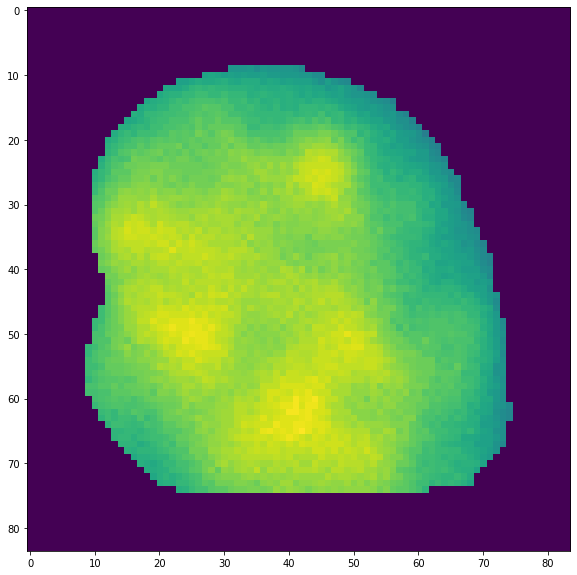

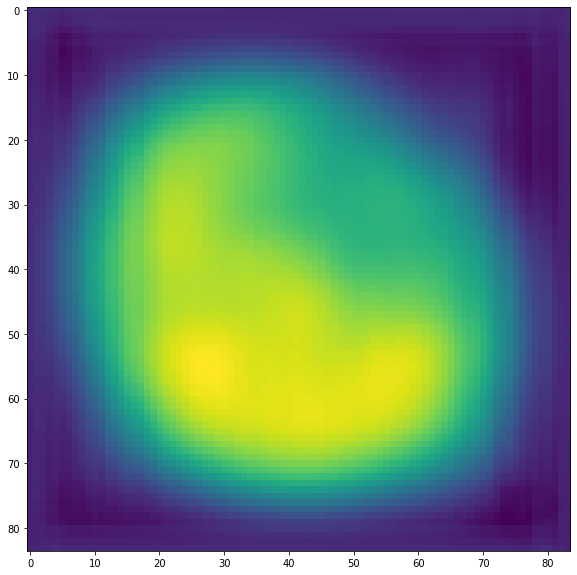

>>> epoch [701/1000], loss:0.0069, time:608.00s


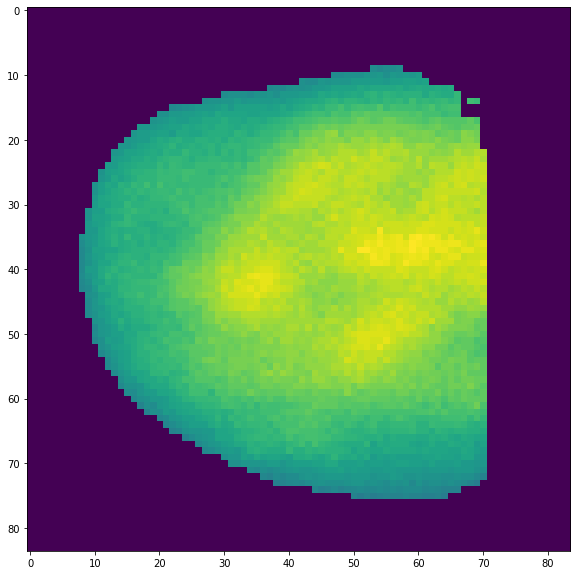

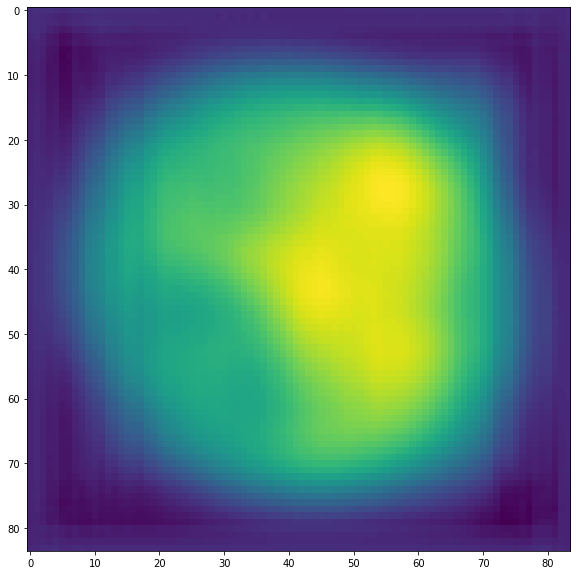

>>> epoch [801/1000], loss:0.0063, time:673.00s


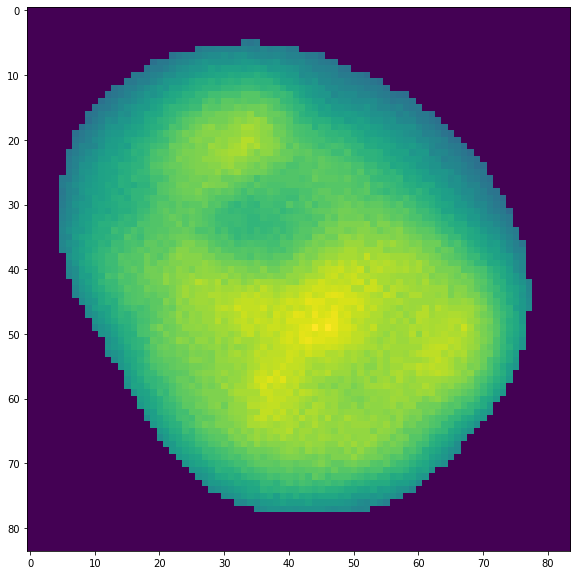

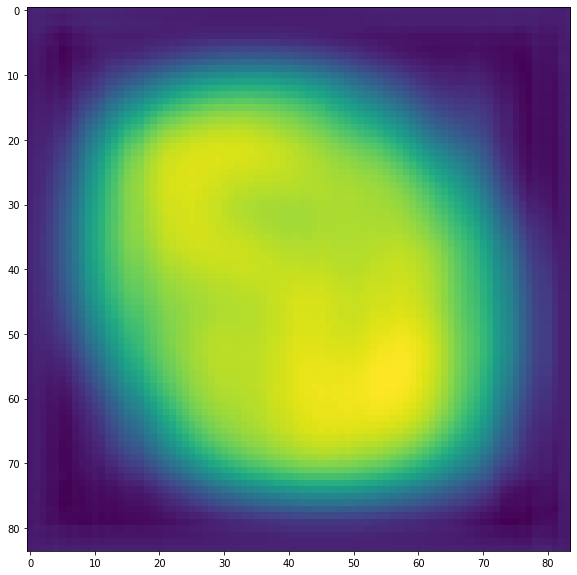

>>> epoch [901/1000], loss:0.0042, time:738.00s


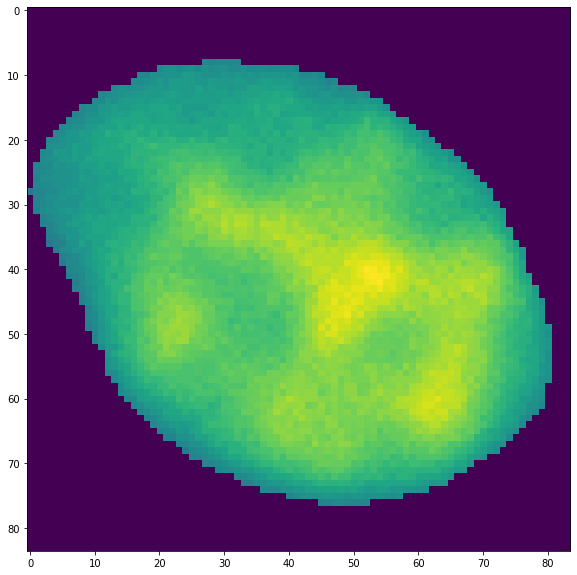

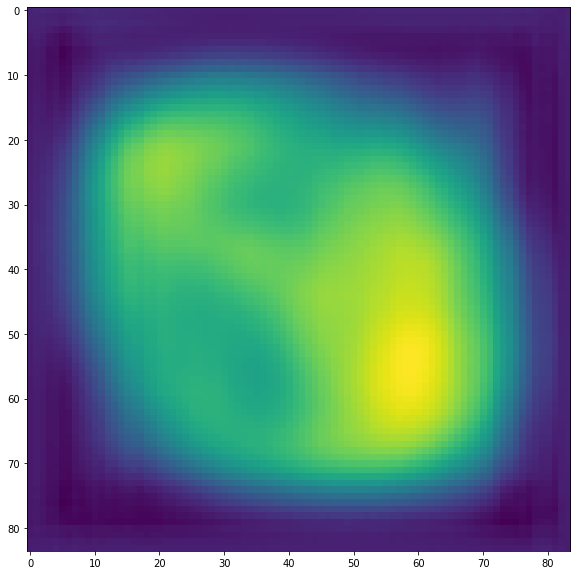

In [98]:
if not os.path.exists('./convae_output'):
    os.mkdir('./convae_output')

def to_img(x):
    x = x.view(x.size(0), 3, 84, 84)
    return x

num_epochs = 1000

for epoch in range(num_epochs):
    for img in dataloader:
        img = Variable(img.float()).cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        output = model(img)
        loss = criterion(output, img)
        # backward
        loss.backward()
        optimizer.step()
        
    # ===================log========================
    endtime = datetime.datetime.now()
    if epoch % 100 == 0: 
        print('>>> epoch [{}/{}], loss:{:.4f}, time:{:.2f}s'.format(epoch+1, num_epochs, loss.item(), (endtime-starttime).seconds))
        img = np.transpose(img.cpu().data, (0, 2, 3, 1))
#         print(img[1,:,:,0])
        plt.figure(figsize=(10,10))
        plt.imshow(img[4,:,:,0])
        plt.show()
        
        pic = output.cpu().data
        pic = np.transpose(pic, (0, 2, 3, 1))
#         print(pic[1,:,:,0])
        plt.figure(figsize=(10,10))
        plt.imshow(pic[4,:,:,0])
        plt.show()

        pic = to_img(output.cpu().data)
        save_image(pic, './convae_output/image_{}.png'.format(epoch))
    torch.save(model.state_dict(), './conv_autoencoder.pth')

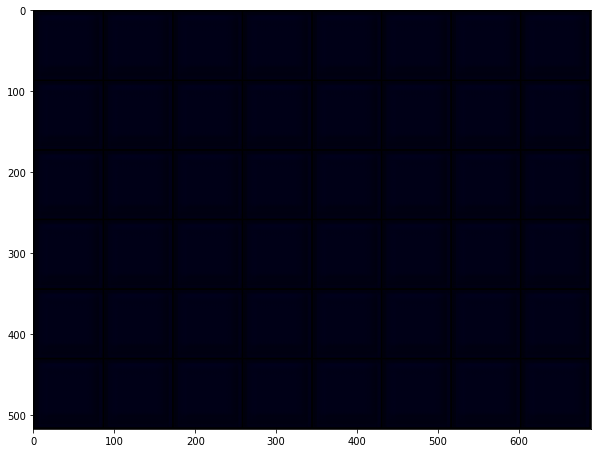

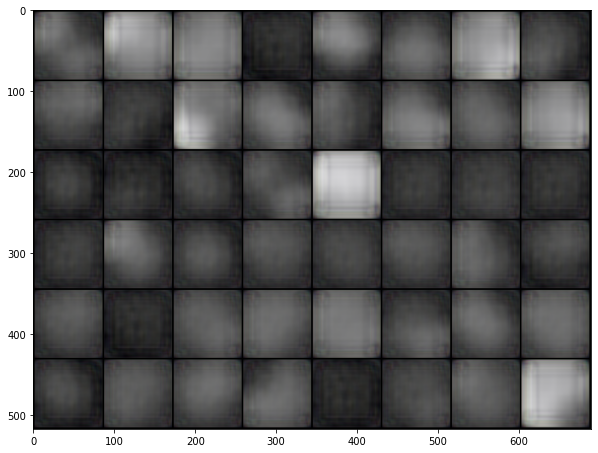

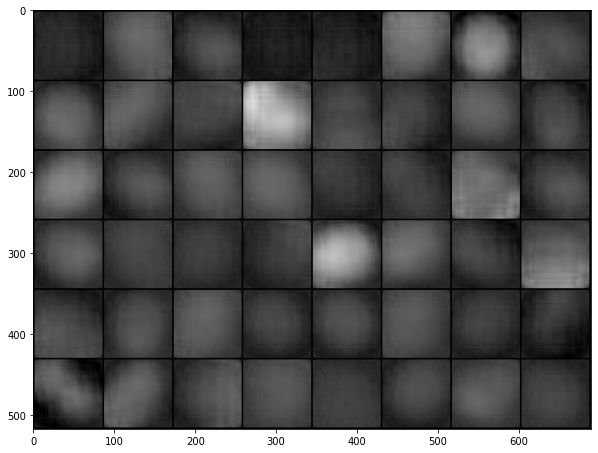

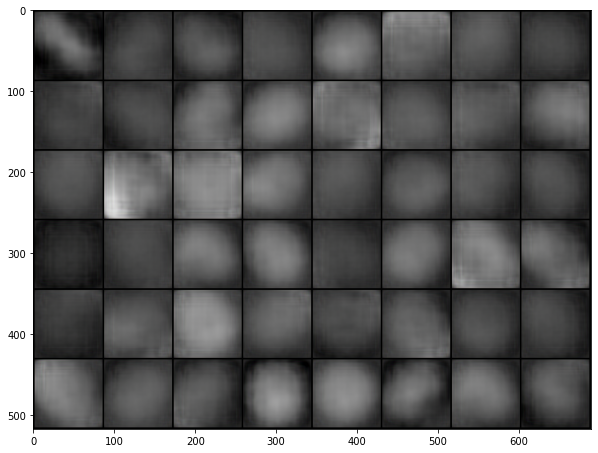

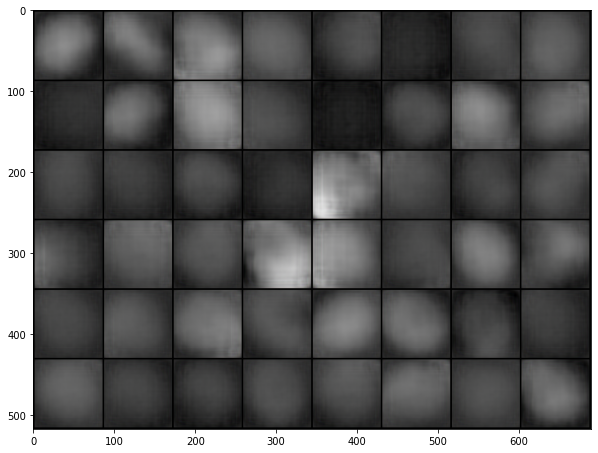

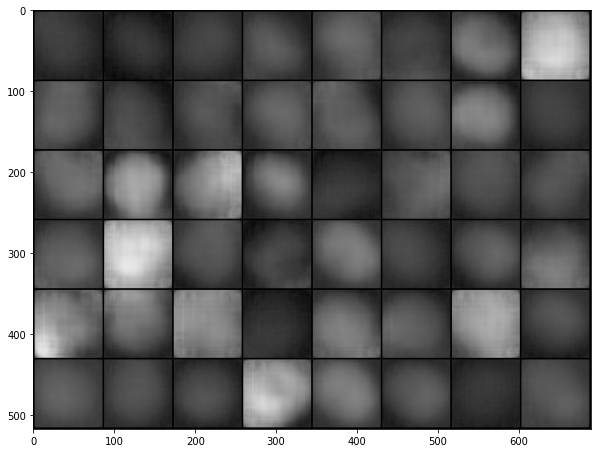

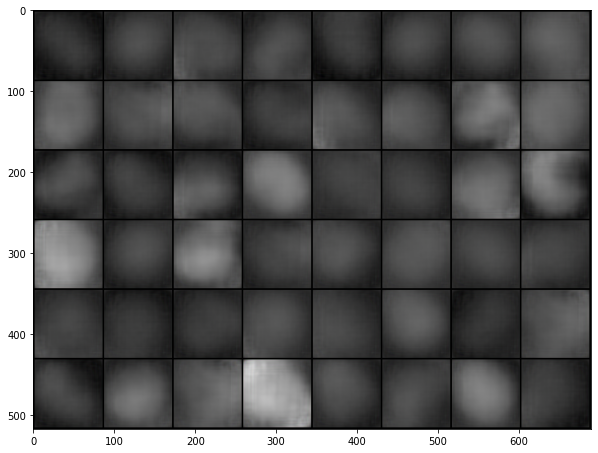

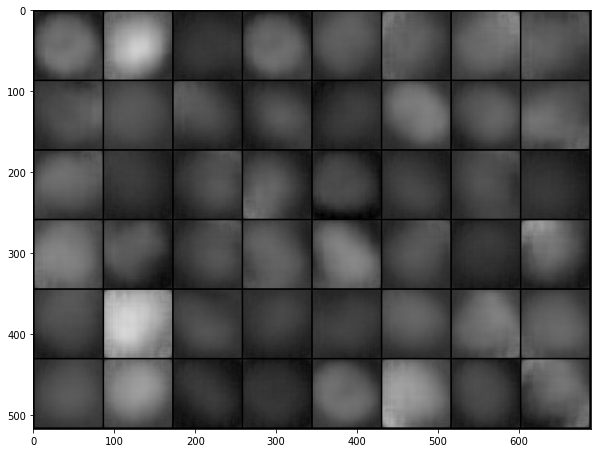

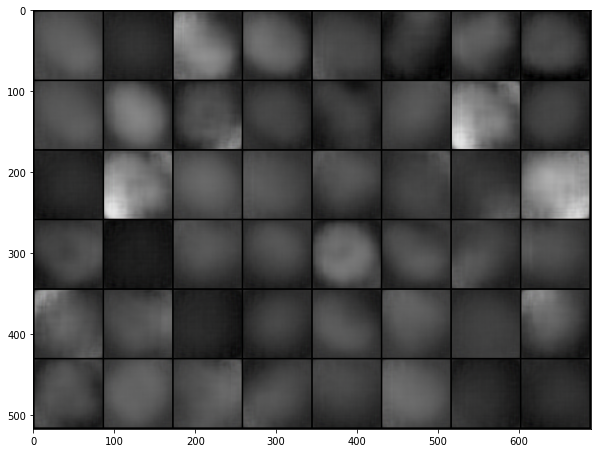

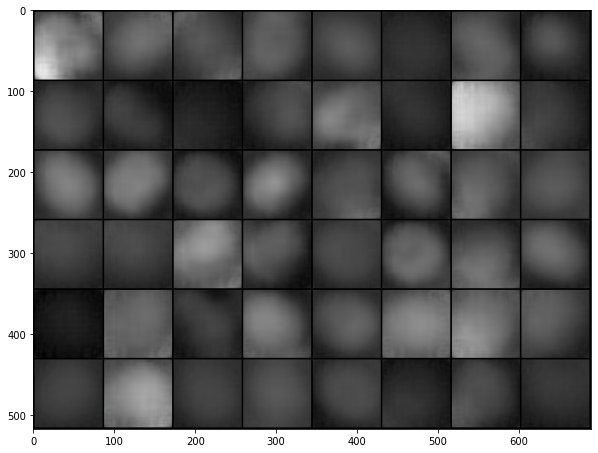

In [4]:
for i in range(0,10000,1000):
    plt.figure(figsize=(10,10))
    img=cv2.imread("./convae_output/image_"+str(i)+".png")
    plt.imshow(img)
    plt.show()